# Big data in little laptop

*Juan Nunez-Iglesias*  
*Victorian Life Sciences Computation Initiative*  
*University of Melbourne*  

This talk is inspired by the work of Matt Rocklin

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)

# Two types of data

# Three types of data

# "Traditional"/"batch" programming

Take the mean of log(r) + 1 over all rows r in a dataset

In [ ]:
import numpy as np

fin = 'data/expr.tsv'
counts = np.loadtxt(fin)
logcounts = np.log(counts + 1)
lcmean = np.mean(logcounts, axis=0)

print(lcmean)

# Simple streaming: grep

In [ ]:
def simplegrep(pattern, filename):
    with open(filename) as fin:
        for linenum, line in enumerate(fin):
            if pattern in line:
                print(linenum, ':', line)

In [ ]:
%ls -l data

In [ ]:
import sys
sys.path.append('/Users/jni/projects/ipython_memory_usage/')
import ipython_memory_usage as imu

In [ ]:
imu.start_watching_memory()

In [ ]:
%%timeit -n 1 -r 1
simplegrep('chrUn_DS484746v1', 'data/dm6.fa')

In [ ]:
imu.stop_watching_memory()

# A bit harder: multi-function streaming with `yield`

Revisiting log-mean

In [ ]:
import numpy as np

def line2array(line):
    return np.array(line.rstrip().split(), dtype=float)

def readtsv(filename):
    with open(filename) as fin:
        for i, line in enumerate(fin):
            yield line2array(line)

def log(arrays_iter):
    for i, arr in enumerate(arrays_iter):
        yield np.log(arr + 1)

def mean(arrays_iter):
    for i, arr in enumerate(arrays_iter):
        if i == 0:
            mean = arr
        mean += (arr - mean) / (i + 1)
    return mean

print(mean(log(readtsv(fin))))

In [ ]:
import numpy as np

def line2array(line):
    return np.array(line.rstrip().split(), dtype=float)

def readtsvv(filename):
    print('starting readtsv')
    with open(filename) as fin:
        for i, line in enumerate(fin):
            print('reading line {}'.format(i))
            yield line2array(line)
    print('finished readtsv')

def logv(arrays_iter):
    print('starting log')
    for i, arr in enumerate(arrays_iter):
        print('taking log of line {}'.format(i))
        yield np.log(arr + 1)
    print('finished log')

def meanv(arrays_iter):
    print('starting running mean')
    for i, arr in enumerate(arrays_iter):
        if i == 0:
            mean = arr
        mean += (arr - mean) / (i + 1)
        print('adding line {} to the running mean'.format(i))
    print('returning mean')
    return mean

In [ ]:
print(meanv(logv(readtsvv(fin))))

# Toolz: making streaming beautiful

In [ ]:
import toolz as tz

tz.pipe(fin, readtsv, log, mean)

In [ ]:
from toolz.curried import map as cmap

def log1(arr):
    return np.log(arr + 1)

tz.pipe(fin, open,
        cmap(line2array),
        cmap(log1),
        mean)

# Streaming PCA

In [ ]:
from toolz.curried import partition
from sklearn import decomposition

def streaming_pca(samples, n_components=2, batch_size=50):
    ipca = decomposition.IncrementalPCA(n_components=n_components,
                                        batch_size=batch_size)
    # we use `tz.last` to force evaluation of the full iterator
    tz.last(tz.pipe(samples,  # iterator of 1D arrays
                    partition(batch_size),  # iterator of tuples
                    cmap(np.array),  # iterator of 2D arrays
                    cmap(ipca.partial_fit)))  # partial_fit on each
    return ipca

In [ ]:
pca = tz.pipe('data/iris_data.txt', open,
              cmap(line2array),
              streaming_pca)

In [ ]:
X = tz.pipe('data/iris_data.txt', open,
            cmap(line2array),
            cmap(pca.transform),
            list, np.squeeze)

In [ ]:
from matplotlib import pyplot as plt

def plot_embedding(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1],
                    color=plt.cm.Set1(y[i] / 10.))
    plt.xticks([]), plt.yticks([])

In [ ]:
y = np.loadtxt('data/iris_target.txt')
plot_embedding(X, y)

# k-mer counting

15-mer  
"to be or nob to”  
much less frequent than  
“to be or not to"

In [ ]:
from toolz.curried import sliding_window, filter as cfilter

def is_sequence(line):
    return not line.startswith('>')


from glob import glob

k = 7
counts = tz.pipe('*.fasta', glob, cmap(open),
                 tz.concat,  # lines
                 cfilter(is_sequence),  # discard names
                 cmap(str.rstrip),
                 cmap(sliding_window(k)),  # apply sliding to each
                 tz.concat,  # k-mers as char tuples
                 cmap(''.join),  # k-mers
                 tz.frequencies)

counts = list(counts.values())

In [ ]:
def integer_histogram(counts, normed=True, *args, **kwargs):
    hist = np.bincount(counts)
    if normed:
        hist = hist / np.sum(hist)
    return plt.plot(np.arange(len(hist)), hist, *args, **kwargs)

In [ ]:
integer_histogram(counts, lw=2)
plt.xlim(-1, 250)

# Genome markov model

In [ ]:
import numpy as np
import toolz as tz
import cytoolz as ctz
from glob import glob
import itertools as it

In [ ]:
LDICT = dict(zip('ACGTacgt', range(8)))
PDICT = {(a, b): (LDICT[a], LDICT[b])
         for a, b in it.product(LDICT, LDICT)}

def is_nucleotide(letter):
    return letter in LDICT  # ignore 'N'


@tz.curry
def increment_model(model, index):
    model[index] += 1

In [ ]:
def genome(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   cmap(open),  # lines
                   tz.concat,  # concatenate lines from all files
                   cfilter(is_sequence),  # drop header from each sequence
                   tz.concat,  # concatenate chars from all lines
                   cfilter(is_nucleotide))  # discard newlines and 'N'

In [ ]:
def markov(seq):
    """Get a 1st-order Markov model from a sequence of nucleotides."""
    model = np.zeros((8, 8))
    tz.last(tz.pipe(ctz.sliding_window(2, seq),  # each successive tuple
                    cmap(PDICT.__getitem__),  # location in matrix of tuple
                    cmap(increment_model(model))))  # increment matrix
    # convert counts to transition probability matrix
    model /= np.sum(model, axis=1)[:, np.newaxis]
    return model

In [26]:
imu.start_watching_memory()

In [26] used 25.4453 MiB RAM in 3.13s, peaked 0.00 MiB above current, total RAM usage 75.88 MiB


In [27]:
dm = 'data/dm6.fa'
import timeit

t0 = timeit.default_timer()
m = tz.pipe(dm, genome, markov)
t1 = timeit.default_timer()

sec = t1 - t0
print("processed 147MB in %.1fmin" % (sec / 60))
print("throughput: %.2fMBps" % (147 / sec))

processed 147MB in 5.2min
throughput: 0.47MBps
In [27] used 0.0234 MiB RAM in 312.32s, peaked 0.00 MiB above current, total RAM usage 75.90 MiB


In [28]:
imu.stop_watching_memory()

In [29]:
print('    ', '      '.join('ACGTacgt'), '\n')
print(m)

     A      C      G      T      a      c      g      t 

[[ 0.351  0.181  0.189  0.279  0.     0.     0.     0.   ]
 [ 0.322  0.223  0.199  0.255  0.     0.     0.     0.   ]
 [ 0.261  0.272  0.223  0.243  0.     0.     0.     0.   ]
 [ 0.216  0.194  0.239  0.351  0.     0.     0.     0.   ]
 [ 0.001  0.001  0.001  0.001  0.349  0.184  0.18   0.283]
 [ 0.001  0.001  0.001  0.001  0.327  0.211  0.185  0.273]
 [ 0.001  0.001  0.001  0.001  0.28   0.229  0.209  0.277]
 [ 0.001  0.001  0.001  0.001  0.247  0.185  0.216  0.348]]


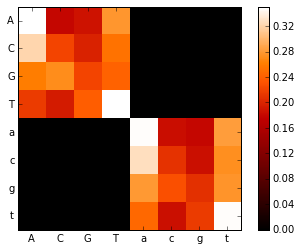

In [30]:
plt.imshow(m, cmap='gist_heat', interpolation='nearest');
plt.colorbar();
ax = plt.gca()
ax.set_xticklabels(' ACGTacgt');
ax.set_yticklabels(' ACGTacgt');

# Cheat sheet

- `[x[5] for x in xs]` -> `(x[5] for x in xs)`
- iterators need to be consumed:
  * `map(func, very_long_iter)` does no work
  * `sum(map(func, very_long_iter))` applies `func` and `sum`
  * `very_long_iter` is then *gone* and you can't use it again.
  * `sum(map(func, very_long_iter))` is now 0
- `toolz.pipe` and `toolz.curried`


# Other examples

**Stacking and montaging images from microscope**

In [ ]:
tz.pipe(ims, partition(nchannels),
             cmap(stack_channels(order=channel_order)),
             partition(ntiles),
             cmap(montage(order=tile_order))

**Reservoir sampling pixels from many images**

In [ ]:
ims_iter = iter(ims_iter)  # ensure iterator and not e.g. list
sampled = next(ims_iter)
for k, im in enumerate(ims_iter, start=2):
    to_replace = np.random.rand(*im.shape) < (1 / k)
    sampled[to_replace] = im[to_replace]
return sampled

**Correcting image illumination**

In [ ]:
p0 = 100 * stretch_quantile
p1 = 100 - p0
im_fns = list(im_fns)

# in first pass, make a composite image to get global intensity range
ims_pass1 = map(io.imread, im_fns)
sampled = _reservoir_sampled_image(ims_pass1, random_state)
corrected = sampled / illum  # don't do in-place, dtype may clash
corr_range = tuple(np.percentile(corrected, [p0, p1]))

# In second pass, correct every image and adjust exposure
ims_pass2 = map(io.imread, im_fns)
for im in ims_pass2:
    corrected = im / illum
    rescaled = exposure.rescale_intensity(corrected, in_range=corr_range,
                                              out_range=np.uint8)
    out = np.round(rescaled, out=np.empty(rescaled.shape, np.uint8))
    yield out

In [31]:
# throughput of single chars

def chars(filename):
    return tz.concat(open(filename))
t = %timeit -o tz.last(tz.take(1004656, chars(dm)))
throughput = 1 / t.best
print(throughput, "MBps")

10 loops, best of 3: 38.4 ms per loop
26.03523155778172 MBps


In [32]:
t = %timeit -o tz.last(tz.take(int(1e6), genome(dm)))
throughput = 1 / t.best
print(throughput, "MBps")

1 loops, best of 3: 327 ms per loop
3.0577990840068923 MBps


In [33]:
t = %timeit -o markov(tz.take(int(1e6), genome(dm)))
throughput = 1 / t.best
print(throughput, "MBps")

1 loops, best of 3: 2.32 s per loop
0.4302326505645628 MBps
